In [1]:
import numpy as np
np.random.seed(42)

In [2]:
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [3]:
def denormalize(y, y_scale, y_offset):
    y_log = (y - y_offset) / y_scale
    y_denormed = K.exp(y_log) - 1e-9
    return y_denormed

In [4]:
def count_density(y):
    # Return (batch_size, 1)
    return K.sum(K.sum(K.sum(y, axis=-1), axis=-1), axis=-1, keepdims=True)

In [5]:
def get_unet(n_channels=3, n_classes=1, batch_norm=False, y_scale=1.0, y_offset=0):
    DenormLayer = Lambda(denormalize, arguments={"y_scale": y_scale, "y_offset": y_offset})
    CountLayer = Lambda(count_density)
    
    # Fully convolutional, we don't specify the image size
    inputs = Input((None, None, n_channels))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    if batch_norm:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    if batch_norm:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    if batch_norm:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    if batch_norm:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    if batch_norm:
        conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    if batch_norm:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    if batch_norm:
        conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    if batch_norm:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    if batch_norm:
        up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    if batch_norm:
        conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    if batch_norm:
        up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    if batch_norm:
        conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    if batch_norm:
        up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    if batch_norm:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    if batch_norm:
        up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    if batch_norm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    if batch_norm:
        conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=None)(conv9)
    conv10_denormed = DenormLayer(conv10)
    count = CountLayer(conv10_denormed)
    
    model = Model(inputs=[inputs], outputs=[conv10, count])

    return model

In [6]:
def count_rmse_capped(y_true, y_pred):    
    rmse = K.sqrt(K.mean(K.square(y_true - y_pred)))
    return K.clip(rmse, 0, 10)

In [7]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise Exception("Can't find block...??")

In [8]:
def normalize_image(im):
    n_channels = im.shape[2]
    im_normed = im.copy()
    
    for c in range(n_channels):
        min_channel = np.min(im[:,:,c])
        max_channel = np.max(im[:,:,c])
        a = 255.0/(max_channel - min_channel)
        b = -a * min_channel
        im_normed[:,:,c] = (a * im[:,:,c] + b).astype(np.uint8)
        
    return im_normed

In [9]:
class StreamStats(object):
    """ See https://www.johndcook.com/blog/standard_deviation/
    """
    def __init__(self):
        self.M = None
        self.S = None
        self.k = 0
        self.min = None
        self.max = None
        
    def update(self, x):
        self.k += 1
        if self.k == 1:
            self.M = x
            self.S = 0
            self.min = x
            self.max = x
        else:
            prevM = self.M
            prevS = self.S
            self.M = prevM + (x - prevM)/self.k
            self.S = prevS + (x - prevM) * (x - self.M)
            self.min = np.minimum(x, self.min)
            self.max = np.maximum(x, self.max)
            
    def mean(self):
        return self.M
        
    def variance(self):
        if self.k - 1 > 0:
            return self.S / (self.k - 1)
        else:
            return 0
    
    def std(self):
        return np.sqrt(self.variance())
    
    def minimum(self):
        return self.min
    
    def maximum(self):
        return self.max

In [10]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 x_scale=None, x_offset=None, y_scale=None, y_offset=None,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42):
        
        self.image_ids = image_ids
        self.x_scale = 1.0 if x_scale is None else x_scale
        self.x_offset = 0.0 if x_offset is None else x_offset
        self.y_scale = 1.0 if y_scale is None else y_scale
        self.y_offset = 0.0 if y_offset is None else y_offset
        self.root_dir = root_dir
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def load_stats(self):
        self.x_scale = np.load(os.path.join(self.root_dir, "x_scale.npy"))
        self.x_offset = np.load(os.path.join(self.root_dir, "x_offset.npy"))
        self.y_scale = np.load(os.path.join(self.root_dir, "y_scale.npy"))
        self.y_offset = np.load(os.path.join(self.root_dir, "y_offset.npy"))
        
    def compute_stats(self, n_batches=100):
        input_stats = StreamStats()
        log_output_stats = StreamStats()
        scaled_output_stats = StreamStats()
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(bx.shape[0]):
                x = bx[b,...]
                x_normed = normalize_image(x)
                x_mean_bgr = np.mean(np.mean(x_normed/255, axis=0), axis=0)
                input_stats.update(x_mean_bgr)
            for b in range(by.shape[0]):
                y_log = by[b,...]
                for vy in y_log.ravel():
                    log_output_stats.update(vy)
                    
        self.x_scale = 1/(255 * input_stats.std())
        self.x_offset = -input_stats.mean()/input_stats.std()
        np.save(os.path.join(self.root_dir, "x_scale.npy"), self.x_scale)
        np.save(os.path.join(self.root_dir, "x_offset.npy"), self.x_offset)
        
        ylog_min = log_output_stats.minimum()
        ylog_max = log_output_stats.maximum()        
        a1 = 1/(ylog_max - ylog_min )
        b1 = -a1 * ylog_min
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(by.shape[0]):
                y_log = by[b,...]
                y_scaled = a1 * y_log + b1
                for vy in y_scaled.ravel():
                    scaled_output_stats.update(vy)
        
        a2 = 1/scaled_output_stats.std()
        b2 = -scaled_output_stats.mean()/scaled_output_stats.std()
        self.y_scale = a1 * a2
        self.y_offset = a2 * b1 + b2
        np.save(os.path.join(self.root_dir, "y_scale.npy"), self.y_scale)
        np.save(os.path.join(self.root_dir, "y_offset.npy"), self.y_offset)        

    def __normalize_input__(self, x):
        return x * self.x_scale + self.x_offset
    
    def __normalize_output__(self, y):
        ylog = np.log(y + 1e-9)
        return ylog * self.y_scale + self.y_offset
    
    def denormalize_output(self, y_normed):
        y_log = (y_normed - self.y_offset)/self.y_scale
        return np.exp(y_log) - 1e-9
    
    def denormalize_input(self, x_normed):
        return(x_normed - self.x_offset)/self.x_scale
    
    def __sample__(self, shape, dots, image_id):
        pbackground = 0.2
        threshold_masked = 0.3 # if more than 30% of the patch is masked, reject it
        
        adots = []
        for _, ds in dots.items():
            for x, y in ds:
                if 0 <= x < shape[1] and 0 <= y < shape[0]:
                    adots.append((x, y))
                    
        bg_or_dots = np.random.choice(2, size=(1, ), p=[pbackground, 1-pbackground])
        
        while 1:
            if bg_or_dots[0] == 0 or len(adots) == 0:
                x, y = self.sample_bg(shape, image_id)
            else:
                x, y = self.sample_dot(shape, adots, image_id)

            try:
                bid, x, y = get_block_loc(shape, x, y)
            except:
                continue
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainDensity", uid + ".npz"))['dmap']
                dmap = np.sum(dmap, axis=-1, keepdims=True)
                dmap_patch = dmap[y:y+self.target_size[0], x:x+self.target_size[1], :]
                return img_patch, dmap_patch
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, adots, image_id):
        half_size = 36
        
        randi = np.random.choice(len(adots), size=(1,))[0]
        rand_dot = adots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x >= max_x:
            max_x, min_x = min_x, max_x
        if min_y >= max_y:
            max_y, min_y = min_y, max_y 
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 1), dtype=K.floatx())
        batch_ycount = np.zeros((current_batch_size, 1), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.__sample__(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i,:,:,:] = y
            batch_ycount[i, 0] = np.sum(y)

        return self.__normalize_input__(batch_x), [self.__normalize_output__(batch_y), batch_ycount]

In [11]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(s[:-4]) for s in train_ids]

In [12]:
with open("../data/sealion/dots_ok.json", "r") as jfile:
    dots_ok = json.load(jfile)
dots_ok = [int(s[:-4]) for s in dots_ok]

In [13]:
train_ids = list(set(train_ids).intersection(set(dots_ok)))

In [14]:
with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(s[:-4]) for s in val_ids]
val_ids = list(set(val_ids).intersection(set(dots_ok)))

In [28]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", train_ids, seed=20)
trainPatchesGenerator.load_stats()

In [29]:
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", val_ids, seed=20)
valPatchesGenerator.load_stats()

In [30]:
unet = get_unet(3, 1, batch_norm=False, y_scale=trainPatchesGenerator.y_scale, y_offset=trainPatchesGenerator.y_offset)

In [31]:
unet.compile(optimizer=Adam(lr=0.001), loss=[mean_squared_error, count_rmse_capped], loss_weights=[0.5, 0.5])

In [32]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=10, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=50, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/10
200/200 [==============================] - 2446s - loss: 2.6117 - conv2d_57_loss: 0.9201 - lambda_6_loss: 4.3034 - val_loss: 3.3589 - val_conv2d_57_loss: 0.8405 - val_lambda_6_loss: 5.8773
Epoch 2/10
200/200 [==============================] - 2533s - loss: 3.0461 - conv2d_57_loss: 0.9889 - lambda_6_loss: 5.1034 - val_loss: 2.5317 - val_conv2d_57_loss: 0.9212 - val_lambda_6_loss: 4.1423
Epoch 3/10
200/200 [==============================] - 2286s - loss: 2.9080 - conv2d_57_loss: 1.0238 - lambda_6_loss: 4.7923 - val_loss: 2.6814 - val_conv2d_57_loss: 0.9546 - val_lambda_6_loss: 4.4081
Epoch 4/10
200/200 [==============================] - 2289s - loss: 2.7015 - conv2d_57_loss: 0.9871 - lambda_6_loss: 4.4159 - val_loss: 2.8533 - val_conv2d_57_loss: 0.9841 - val_lambda_6_loss: 4.7224
Epoch 5/10
200/200 [==============================] - 2316s - loss: 2.9873 - conv2d_57_loss: 1.0283 - lambda_6_loss: 4.9464 - val_loss: 2.5055 - val_conv2d_57_loss: 0.8358 - val_lambda_6_loss: 4.1751


KeyboardInterrupt: 

In [44]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [45]:
batch_ypred = unet.predict(batch_x)

In [46]:
batch_y[1].shape

(8, 1)

In [47]:
batch_ypred[0].shape

(8, 224, 224, 1)

In [48]:
batch_ypred[1]

array([[ 0.00125259],
       [ 0.00125256],
       [ 0.00125259],
       [ 0.00125257],
       [ 0.00125259],
       [ 0.00125259],
       [ 0.00125259],
       [ 0.00125259]], dtype=float32)

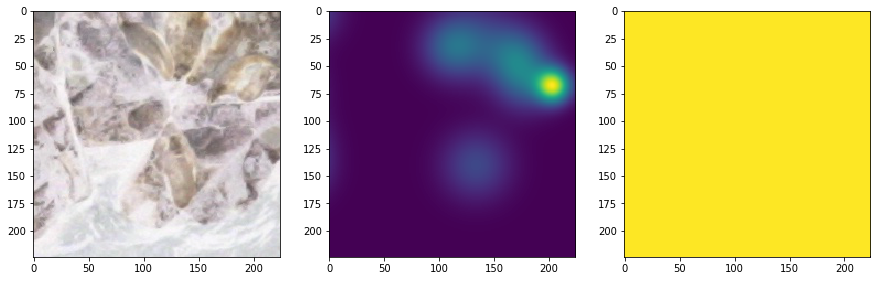

In [49]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(valPatchesGenerator.denormalize_output(batch_y[0][i,:,:, 0]))
plt.subplot(133)
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[0][i,:,:, 0]))

In [ ]:
np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0]))

In [ ]:
np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]))